# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 


## Helper Functions

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [2]:
def filter_lines(hough_lines_result, threshold = 0.3):
    """
    split input lines to right and left
    and remove all lines with slope value less than
    threshold
    """
    left_lines = []
    right_lines = []
    for line in hough_lines_result:
        for x1,y1,x2,y2 in line:
            if (x2 - x1) == 0:
                continue
            slope = (y2 - y1) / (x2 - x1)
            if abs(slope) > threshold:
                if slope > 0:
                    right_lines.append(line)
                else:
                    left_lines.append(line)
    return [left_lines, right_lines]


def line_dist(line1, line2):
    for x1_1,y1_1,x2_1,y2_1 in line1:
        p1=np.array([x1_1,y1_1])
        p2=np.array([x2_1,y2_1])
        for x1_2, y1_2, x2_2, y2_2 in line2:
            p3=np.array([x1_2,y1_2])
            p4=np.array([x2_2,y2_2])
            d1=np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1)
            d2=np.linalg.norm(np.cross(p2-p1, p1-p4))/np.linalg.norm(p2-p1)
            d = (d1+d2)/2
    return d 
            
        
def build_chains(input_lines, is_right, threshold = 50):
    """
    group lines into chains.
    We assume that all input lines are left or right
    """
    chains = []
    for line in input_lines:
        if len(chains) == 0:
            chains.append(line)
            continue
        was_added = False
        for chain in chains:          
                d = line_dist(line, chain)
                if d < threshold:
                    was_added = True
                    for x1_1,y1_1,x2_1,y2_1 in line:
                        for x1_2, y1_2, x2_2, y2_2 in chain:
                            if is_right == False:
                                chain[0][0] = min(x1_1, x2_1, x1_2, x2_2)
                                chain[0][1] = max(y1_1, y2_1, y1_2, y2_2)
                                chain[0][2] = max(x1_1, x2_1, x1_2, x2_2)
                                chain[0][3] = min(y1_1, y2_1, y1_2, y2_2)
                            else:
                                chain[0][0] = min(x1_1, x2_1, x1_2, x2_2)
                                chain[0][1] = min(y1_1, y2_1, y1_2, y2_2)
                                chain[0][2] = max(x1_1, x2_1, x1_2, x2_2)
                                chain[0][3] = max(y1_1, y2_1, y1_2, y2_2)
                            break
        if was_added == False:
            chains.append(line)
    return chains

def find_highest_line(chains, slope_threshold = 0.4):
    """
    calculate distance by y
    """
    if(len(chains) == 0):
        return chains
    result_idx = 0
    max_hight = 0
    for i in range(len(chains)):
        for x1,y1,x2,y2 in chains[i]:
            h = abs(y2-y1)
            slope = h / (x2 - x1) # we do not care about the sigh here
            if max_hight < h and slope > slope_threshold:
                max_hight = h
                result_idx = i
    return chains[result_idx]
 
def find_new_x(x1,y1,x2,y2, y_max):
    slope = (y2 - y1) / (x2 - x1)
    x_new = (y_max - y2) / slope + x2
    return x_new

def extrapolate_lines(img, lines, is_right = False, slope_threshold = 0.3):
    ext_lines = []
    for line in lines:
        [new_line, new_slope] = extrapolate_line(img, line)
        if abs(new_slope) > slope_threshold:
            if (is_right == True) and (new_slope > 0):
                ext_lines.append(new_line)
            elif (is_right == False) and (new_slope < 0):
                ext_lines.append(new_line)
    return ext_lines

def extrapolate_line(img, line):
    for x1,y1,x2,y2 in line:
        if(y2 > y1):
            line[0][3] = img.shape[0]
            line[0][2] = find_new_x(x1,y1,x2,y2, img.shape[0])
        else:
            line[0][1] = img.shape[0]
            line[0][0] = find_new_x(x1,y1,x2,y2, img.shape[0])
        new_slope = (line[0][3] - line[0][1]) / (line[0][2] - line[0][0])
        return [line, new_slope]

## Build a Lane Finding Pipeline



In [8]:
# 1. Read an image
input_img_name = 'whiteCarLaneSwitch.jpg'
input_img = mpimg.imread('test_images/'+input_img_name)
# 2. Convert to grayscal
gray_img = grayscale(input_img)

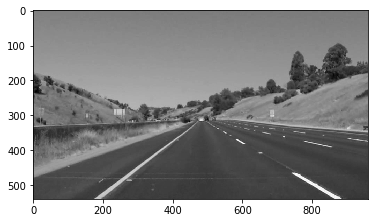

In [9]:
plt.imshow(gray_img, cmap='gray')

In [10]:
# 3. Blur the image
blur_img = gaussian_blur(gray_img, 5)

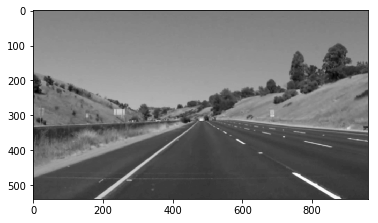

In [85]:
plt.imshow(blur_img, cmap='gray')

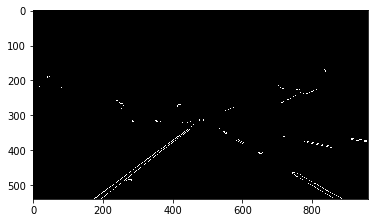

In [86]:
# 4. Apply canny algortihm
low_threshold = 150
high_threshold = 250
edge_img = canny(blur_img, low_threshold, high_threshold)
plt.imshow(edge_img, cmap='gray')

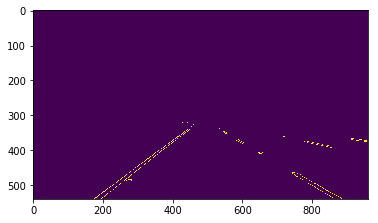

In [87]:
# 5. Apply the ROI
width = edge_img.shape[1]
height = edge_img.shape[0]
height_limit = 320 # chosen for provided test data
vertices = np.array( [[[0,height_limit],[width,height_limit],[width,height],[0,height]]], dtype=np.int32 )
cropped_img = region_of_interest(edge_img, vertices)
plt.imshow(cropped_img)

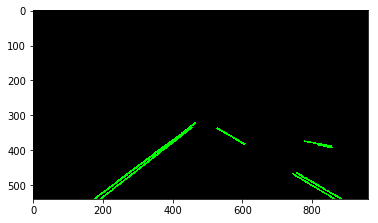

In [88]:
# 6. Apply Hough transformation on found edges
rho = 4 #number of rho values
theta = np.pi/180 #number of theta values
threshold = 100 #voting 
min_line_len = 30
max_line_gap = 30
hough_lines_result = cv2.HoughLinesP(cropped_img, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)
# Draw results
line_img = np.zeros((cropped_img.shape[0], cropped_img.shape[1], 3), dtype=np.uint8)
for line in hough_lines_result:
        for x1,y1,x2,y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), [0, 255, 0], 3)
plt.imshow(line_img)

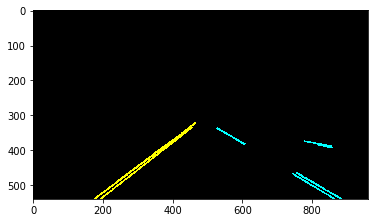

In [89]:
#7. Filter lines
slope_threshold = 0.3
[left_lines, right_lines] = filter_lines(hough_lines_result, slope_threshold)
# Draw results
line_img = np.zeros((cropped_img.shape[0], cropped_img.shape[1], 3), dtype=np.uint8)
for line in left_lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_img, (x1, y1), (x2, y2), [255, 255, 0], 3)
for line in right_lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_img, (x1, y1), (x2, y2), [0, 255, 255], 3)
plt.imshow(line_img)

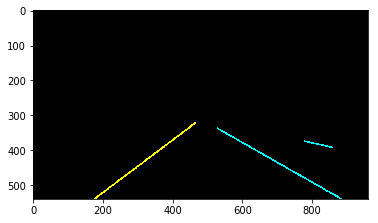

In [90]:
# 8. Concatenate lines
left_chains = build_chains(left_lines, False, 20)
right_chains = build_chains(right_lines, True, 20)
# Draw results
line_img = np.zeros((cropped_img.shape[0], cropped_img.shape[1], 3), dtype=np.uint8)
for line in left_chains:
    for x1,y1,x2,y2 in line:
        cv2.line(line_img, (x1, y1), (x2, y2), [255, 255, 0], 3)
for line in right_chains:
    for x1,y1,x2,y2 in line:
        cv2.line(line_img, (x1, y1), (x2, y2), [0, 255, 255], 3)
plt.imshow(line_img)

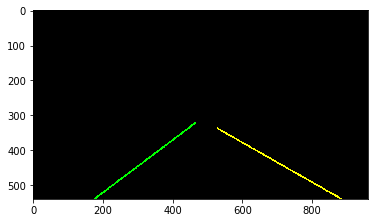

In [91]:
# 9. Choose the best line by slope and lenght parameters
left_result = find_highest_line(left_chains, slope_threshold)
right_result = find_highest_line(right_chains, slope_threshold)
# Draw result
line_img = np.zeros((cropped_img.shape[0], cropped_img.shape[1], 3), dtype=np.uint8)
for x1,y1,x2,y2 in left_result:
        cv2.line(line_img, (x1, y1), (x2, y2), [0, 255, 0], 3)
for x1,y1,x2,y2 in right_result:
        cv2.line(line_img, (x1, y1), (x2, y2), [255, 255, 0], 3)
plt.imshow(line_img)

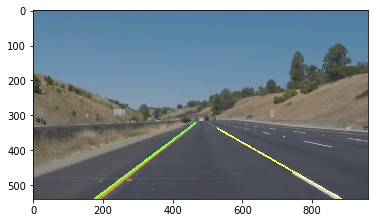

In [92]:
# 10. Apply results on image
result_img = cv2.addWeighted(input_img, 0.8, line_img, 1., 0.)
plt.imshow(result_img)

In [93]:
mpimg.imsave(input_img_name, result_img)

## Test on Videos

In [3]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
def draw_lines_custom(img, lines, slope_threshold = 0.4, thickness=2):
    result_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    # 1. Filter and split lines
    [left_lines, right_lines] = filter_lines(lines, slope_threshold)
    # 2. Build chains for left and right lines separately
    left_chains = build_chains(left_lines, False, 20)
    right_chains = build_chains(right_lines, True, 20)
    if(len(left_chains) > 0):
        # 3. Find "highest" line in chains
        # left_result = find_highest_line(left_chains)
        # 4. Extrapolate line
        is_right = False
        left_result_ext = extrapolate_lines(img, left_chains, is_right, slope_threshold)
        # 5. Draw line
        if(len(left_result_ext)> 0):
            draw_lines(result_img, left_result_ext, [0, 0, 255], thickness)
    if(len(right_chains) > 0):
        # 3. Find "highest" line in chains
        # right_result = find_highest_line(right_chains)
        # 4. Extrapolate line
        is_right = True
        right_result_ext = extrapolate_lines(img, right_chains, is_right, slope_threshold)
        # 5. Draw lines
        if(len(right_result_ext)> 0):
            draw_lines(result_img, right_result_ext, [0, 255, 0], thickness)
    return result_img

In [22]:
def process_image(input_image):
    # Set is_challenge to True before processing challenge video
    is_challenge = False
    # 1. Convert to grayscal
    gray_img = grayscale(input_image)
    # 2. Blur the image
    blur_img = gaussian_blur(gray_img, 5)
    # 3. Apply canny algortihm
    low_threshold = 150
    high_threshold = 250
    edge_img = canny(blur_img, low_threshold, high_threshold)
    # 4. Apply the ROI
    width = edge_img.shape[1]
    height = edge_img.shape[0]
    height_limit = 320 # chosen for provided test data
    if is_challenge == True:
        height_limit = 450
    vertices = np.array( [[[0,height_limit],[width,height_limit],[width,height],[0,height]]], dtype=np.int32 )
    cropped_img = region_of_interest(edge_img, vertices)
    # 5. Apply Hough transformation on found edges
    rho = 4 #number of rho values
    if is_challenge == True:
        rho = 10
    theta = np.pi/180 #number of theta values
    threshold = 100 #voting 
    if is_challenge == True:
        threshold = 60
    min_line_len = 30
    if is_challenge == True:
        min_line_len = 20
    max_line_gap = 30
    hough_lines_result = cv2.HoughLinesP(cropped_img, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)
    # 6. Filter lines by geometrical parameters
    slope_threshold = 0.5
    if is_challenge == True:
        slope_threshold = 0.6
    prefinal_img = draw_lines_custom(cropped_img, hough_lines_result, slope_threshold, thickness=5)
    # 7. Apply result on orig image
    result = weighted_img(prefinal_img, input_image, α=0.8, β=1., γ=0.)
    return result

Let's try the one with the solid white lane on the right first ...

In [12]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 3.83 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [21]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 10.1 s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

For this input following changes in parameters were tested:
1. Upper y bound was lowered to 450 px
2. rho value was increased and minimum length of line was decreased in Hough transformation

As a result line marking was correctly found in most of frames. But also a lot of noise is present.

In [24]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
Wall time: 7.55 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))